<h1>Final Project: Predicting Beer Styles From Homebrewed Recipes<span class="tocSkip"></span></h1>


<h1>Table of Contents<span class="tocSkip"></span></h1>
<br>
<div class="toc"><ul class="toc-item">
    <li><span><a href="#Libraries-Used" data-toc-modified-id="Libraries-Used-1">Libraries Used</a></span></li>
    <li><span><a href="#Ingest-Data" data-toc-modified-id="Ingest-Data-5">Ingest Data</a></span></li>
    <li><span><a href="#Inspect-Data" data-toc-modified-id="Inspect-Data-6">Inspect Data</a></span></li>
    <li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-7">Feature Engineering</a>
    <li><span><a href="#Initial-Model-Fitting" data-toc-modified-id="Initial-Model-Fitting-8">Initial Model Fitting</a></span></li>
    <li><span><a href="#New-Modeling-With-Grouped-Style-Categories" data-toc-modified-id="New-Modeling-With-Grouped-Style-Categories-9">New Modeling With Grouped Style Categories</a></span></li>
    <li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-10">Conclusion</a></span></li>  
</span></li>

</ul></div>

Group Name
-----

EGG

Student Names
----

1. Andrew <b>E</b>aton 
2. Lea <b>G</b>enuit
3. Jacob <b>G</b>offin

## Libraries Used
-----

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from seaborn import heatmap

from scipy.stats import uniform

from sklearn.model_selection import train_test_split
from sklearn import impute
from sklearn import compose
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

## Ingest Data
-----

In [2]:
data = pd.read_csv('recipeData.csv', encoding="ISO-8859-1")

<b> Data is from Kaggle, https://www.kaggle.com/jtrofe/beer-recipes/data, scraped from a homebrewing website. We are trying to predict the StyleID/Style classes given the other variables about the brewing process</b>

In [3]:
pd.set_option("display.max_columns", None)
data.sample(5)

,BeerID,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount,UserId
59259,59260,Pudgy Muck's Celebrated Cocoa Porter,/homebrew/recipe/view/475973/pudgy-muck-s-cele...,American Porter,11,18.93,1.078,1.020,7.65,33.39,44.31,22.71,90,1.065,70.0,1.5,Specific Gravity,All Grain,NaN,20.0,NaN,NaN,79546.0
37578,37579,August Centennial IPA,/homebrew/recipe/view/267251/august-centennial...,American IPA,7,4.50,1.059,1.016,5.63,61.23,11.37,5.00,60,1.053,60.0,NaN,Specific Gravity,Partial Mash,NaN,18.0,NaN,NaN,49733.0
1816,1817,Altbier Dusseldorf Harvat,/homebrew/recipe/view/56388/altbier-dusseldorf...,Dusseldorf Altbier,51,20.82,1.051,1.013,5.06,33.48,12.99,28.39,60,NaN,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,1109.0
33247,33248,Big Wave Island Ale - Extract,/homebrew/recipe/view/361401/big-wave-island-a...,Blonde Ale,30,20.82,1.048,1.009,5.11,22.30,5.31,11.36,60,1.088,35.0,NaN,Specific Gravity,extract,NaN,NaN,NaN,NaN,NaN
31520,31521,Awesome Recipe,/homebrew/recipe/view/209527/awesome-recipe,Sweet Stout,162,20.82,1.065,1.016,6.40,39.97,40.00,28.39,60,1.048,75.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,NaN


In [4]:
# Remove observations that are not beers
beers = data.loc[~data.Style.isin(['Traditional Perry', 'French Cider', 'Pyment (Grape Melomel)',
                                   'Apple Wine', 'New England Cider', 'Metheglin', 'Open Category Mead',
                                   'Cyser (Apple Melomel)', 'Fruit Cider', 'English Cider', 'Sweet Mead',
                                   'Other Specialty Cider or Perry', 'Wheatwine', 'Semi-Sweet Mead',
                                   'Other Fruit Melomel', 'Dry Mead', 'Common Cider', 'Braggot'])]
beers = beers.loc[~beers.Style.isna()]

In [5]:
print(f"Number of classes: {len(set(beers.Style))}")

Number of classes: 157


## Inspect Data
-----

In [6]:
# Show most common styles
df_stylecat = beers.Style.value_counts().to_frame()
df_stylecat['percentage'] = df_stylecat.Style * 100 / sum(df_stylecat.Style)
df_stylecat

,Style,percentage
American IPA,11940,16.434284
American Pale Ale,7581,10.434531
Saison,2617,3.602054
American Light Lager,2277,3.134076
American Amber Ale,2038,2.805115
...,...,...
Piwo Grodziskie,15,0.020646
Pre-Prohibition Porter,12,0.016517
Specialty Wood-Aged Beer,11,0.015140
London Brown Ale,8,0.011011


<b> What columns have a high percentage of null values?</b>

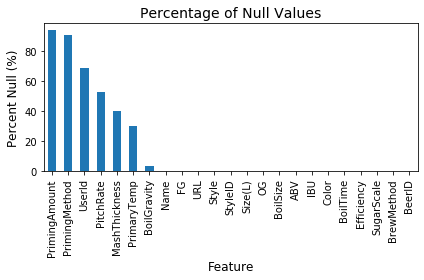

In [7]:
nulls = (beers.isnull().sum() / beers.shape[0] * 100.00)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Percent Null (%)', fontsize=12)
plt.title('Percentage of Null Values', fontsize=14)
nulls.sort_values(ascending=False).plot(kind='bar')
plt.tight_layout()

<b>What categorical columns have high cardinality? </b>

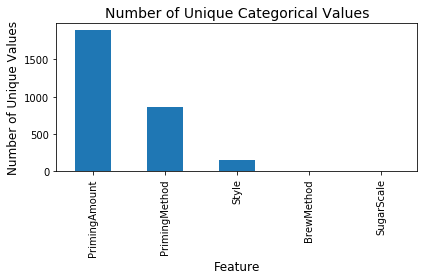

In [8]:
categoricals = list(beers.select_dtypes(include=object).columns)
categoricals = [x for x in categoricals if x not in ['Name', 'URL']]
res = {col: len(beers[col].value_counts()) for col in categoricals}
vals = pd.DataFrame.from_dict(list(res.items())).T
vals.columns = categoricals
vals = vals.iloc[1]
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Number of Unique Values', fontsize=12)
plt.title('Number of Unique Categorical Values', fontsize=14)
vals.sort_values(ascending=False).plot(kind='bar')
plt.tight_layout()

<b> Note on some variables: </b>  

- <b>OG:</b> Specific gravity of wort before fermentation.  
- <b>FG:</b> Specific gravity of wort after fermentation.  
- <b>ABV:</b> Alcohol By Volume. Some observations have 0 values which we think indicate missing values for this variable. 
- <b>Size(L):</b> Amount brewed for recipe listed. This variable is not related with the flavor/style of a beer so we decided to drop it .
- <b>Color:</b> Standard Reference Method - light to dark (ex. 40 = black).
- <b>SG:</b> Specific Gravity is a measure of the relative density of one material compared to another. For brewing, the reference material is water, so the specific gravity of wort or beer is simply the density of the liquid divided by the density of water. As a reference, pure water would have a specific gravity of 1.000.  
- <b>IBU:</b> International Bitterness Units is a measure of the beer's bitterness.
- <b>Boil size:</b> Fluid at beginning of boil. This variable is not related with the flavor/style of a beer so we decided to drop it .
- <b>Boil Time:</b> Time wort is boiled.
- <b>Boil Gravity:</b> Specific gravity of wort before the boil.  
- <b>Sugar Scale:</b> Scale to determine the concentration of dissolved solids in wort. Only two possible values: 'Specific Gravity' or 'Plato'. This variable is not related with the flavor/style of a beer so we decided to drop it .
- <b>Primary Temp:</b> Temperature at the fermenting stage.  
- <b>Efficiency:</b> Mash efficiency is a measurement of the percent of available sugars obtained through the mashing process.  
- <b>Mash thickness:</b> It's the amount of water per pound of grain.  
- <b>Pitch rate:</b> refers to the amount of yeast that is added to cooled wort.  Pitch rate is generally referred to in cells per milliliter.  For home brewers it is difficult to know how much yeast is in the fermenter.
- <b>Priming Method:</b> Priming Sugar is any sugar added to a fermented beer with the purpose of starting a secondary re fermentation. So the values for PrimingMethod indicates the type of sugar used. Missing values probably indicates no Priming used.

## Feature Engineering
-----

<b> For columns with high % of nulls, create a new column to flag if missing or not </b>

In [9]:
beers['PrimingMethod_missing'] = beers.PrimingMethod.isna().astype('float')
beers['MashThickness_missing'] = beers.MashThickness.isna().astype('float')
beers['PitchRate_missing'] = beers.PitchRate.isna().astype('float')

<b> The change in specific gravity (from Original to Final) can say something about beer style, according to online literature </b>

In [10]:
beers['Gravity_diff'] = beers.FG - beers.OG

<b> In our pipeline we handle four separate cases of columns:
<ol>
    <li> Continuous variables with missing values we impute with the median (and scale if flag is set to true, for models like logistic regression & kNN)
    <li> Continuous variables that use zero as a placeholder for missing values, we impute zero with the median. And then scale if flag is set to true
    <li> Categorical variables are imputed with the most frequent value, and then one-hot-encoded
    <li> Boolean variables (is_missing e.g.) are left alone ('passthrough')
</ol>    
** NOTE: We have imbalanced classes, so we attempted to use SMOTE for minority-class upsampling but it didn't produce a significant effect in any of our models, especially in our final/best model (Random Forest)  
</b>

In [11]:
def make_pipeline(classifier=None, scaled=False):
    """
    Create a single pipeline that processes the data and then fits the classifier
    """

    continuous_var = ['MashThickness', 'BoilGravity', 'PrimaryTemp',
                      'OG', 'FG', 'IBU', 'Color', 'BoilTime',
                      'Efficiency', 'Gravity_diff']
    categorical_var = ['BrewMethod']
    fill_zeros_var = ['ABV']
    boolean_var = ['PrimingMethod_missing',
                   'MashThickness_missing', 'PitchRate_missing']

    if scaled:
        continuous_transformer = Pipeline(steps=[
            ('imputer', impute.SimpleImputer(strategy='median')),
            ('normalize', preprocessing.StandardScaler())
        ])
        fill_zeros_transformer = Pipeline(steps=[
            ('imputer', impute.SimpleImputer(missing_values=0, strategy='median')),
            ('normalize', preprocessing.StandardScaler())
        ])
    else:
        continuous_transformer = Pipeline(steps=[
            ('imputer', impute.SimpleImputer(strategy='median'))
        ])
        fill_zeros_transformer = Pipeline(steps=[
            ('imputer', impute.SimpleImputer(missing_values=0, strategy='median'))
        ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', impute.SimpleImputer(strategy='most_frequent')),
        ('encoder', preprocessing.OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = compose.ColumnTransformer(
        transformers=[
            ('continuous_var', continuous_transformer, continuous_var),
            ('categorical_var', categorical_transformer, categorical_var),
            ('fill_zeros_var', fill_zeros_transformer, fill_zeros_var),
            ('boolean_var', 'passthrough', boolean_var)
        ])

    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', classifier)])

    return pipeline

## Initial Model Fitting
------

<b> The dataset is imbalanced so we decided to use weighted F1-score as our North Star metric. </b>

<b> Train-Test Split Data, stratifying on y to keep similar balance of classes in train/test (since we have many classes and they are imbalanced)</b>

In [12]:
y = beers['StyleID']
X = beers.drop(columns=['Style', 'StyleID'])

# Split in train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    random_state=42, stratify=y)

<b> Try Logistic Regression first </b>

In [13]:
lg_classifier = LogisticRegression(solver='lbfgs', multi_class='auto')

In [14]:
pipeLG = make_pipeline(lg_classifier, scaled=True)

In [15]:
pipeLG.fit(X_train, y_train)

/Users/jacobgoffin/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('continuous_var',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                  

<b> Initial Training Score with Logistic Regression <b>

In [16]:
y_pred = pipeLG.predict(X_train)
f1_train = f1_score(y_train, y_pred, average='weighted')
print(f"{f1_train:.4f} F1-score on train dataset")

0.2290 F1-score on train dataset


/Users/jacobgoffin/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<b> Cross Validation Results with Logistic Regression (Scoring with weighted F1) 
* Low score but consistent with training score 
</b>

In [17]:
f1_scorer = make_scorer(f1_score, average='weighted')

In [18]:
print('Cross validation scores:')
k_fold = StratifiedKFold(n_splits=5)
cross_val_score(pipeLG,
                X_train,
                y_train,
                scoring=f1_scorer,
                cv=k_fold)

Cross validation scores:


/Users/jacobgoffin/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/jacobgoffin/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jacobgoffin/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/jacobgoffin/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jacobgoffin/anaconda3/envs/ml/l

array([0.2223507 , 0.22380388, 0.22004858, 0.22426029, 0.22650874])

<b> Repeat Process with Random Forests </b>

In [19]:
rf_classifier = RandomForestClassifier(n_estimators=150, min_samples_leaf=3)

In [20]:
pipeRF = make_pipeline(rf_classifier, scaled=False)

In [21]:
pipeRF.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('continuous_var',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                  

<b> Initial Training Score with Random Forests <b>

In [22]:
y_pred = pipeRF.predict(X_train)
f1_train = f1_score(y_train, y_pred, average='weighted')
print(f"{f1_train:.4f} F1-score on train dataset")

0.8542 F1-score on train dataset


<b> Cross Validation Results with Random Forests (Scoring with weighted F1) 
* Much lower validation scores than in training (overfitting?)
</b>

In [23]:
print('Cross validation scores:')
k_fold = StratifiedKFold(n_splits=5)
cross_val_score(pipeRF,
                X_train,
                y_train,
                scoring=f1_scorer,
                cv=k_fold)

Cross validation scores:


/Users/jacobgoffin/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jacobgoffin/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jacobgoffin/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jacobgoffin/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'pre

array([0.32308928, 0.33034235, 0.32856854, 0.32441326, 0.3288107 ])

<b> Conclusion:</b> With 157 styles of beer to predict, no model was able to get above an f1 score of ~0.35. Therefore we started to think of ways to categorize our beer styles into broader groupings. Luckily we found that there is an official organization, the Beer Judge Certification Program (BJCP), that already does this, classifying beer styles into 34 groups. In the next section we will re-frame our problem to these new style categories and fit new models

## New Modeling With Grouped Style Categories
-----

In [24]:
# Read in Beer Judge Certification Program (BJCP) Mappings, in order to map 157 styles down to 34 "grouped" styles
# https://www.bjcp.org/docs/2015_Guidelines_Beer.pdf
bjcp = pd.read_csv('beerMapping.csv')

In [25]:
mapping = {row['StyleID']: row['BJCP Mapping'] for i, row in bjcp.iterrows()}

In [26]:
beers['StyleCategory'] = beers['StyleID'].map(mapping)

In [27]:
beers = beers.loc[~beers['StyleCategory'].isna()]

In [28]:
print(f"Number of classes: {len(set(beers['StyleCategory']))}")

Number of classes: 34


In [29]:
# Show most common styles
df_stylecat = beers.StyleCategory.value_counts().to_frame()
df_stylecat['percentage'] = df_stylecat.StyleCategory * 100 / sum(df_stylecat.StyleCategory)
df_stylecat

,StyleCategory,percentage
IPA,15416,22.252053
PALE AMERICAN ALE,9334,13.473058
AMBER AND BROWN AMERICAN BEER,4389,6.335253
STANDARD AMERICAN BEER,4207,6.072547
AMERICAN PORTER AND STOUT,3627,5.235353
STRONG BELGIAN ALE,3467,5.004402
GERMAN WHEAT BEER,2508,3.620145
BRITISH BITTER,2481,3.581172
DARK BRITISH BEER,2271,3.278050
PALE BITTER EUROPEAN BEER,1931,2.787280


<b> Train-Test Split Data, stratifying on y to keep similar balance of classes in train/test (since we have many classes and they are imbalanced)</b>

In [30]:
y = beers['StyleCategory']
X = beers.drop(columns=['Style', 'StyleID', 'StyleCategory'])

# Split in train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    random_state=42, stratify=y)

### Create baseline with Logistic Regression (including hyperparameter tuning via randomized-search)

In [31]:
# Common hyperparameters shared across all models
n_iter = 10
cv = 3

# Logistic regression specific hyperparameters
pipeLG = make_pipeline(LogisticRegression(solver="saga", multi_class="auto", verbose=1),
                       scaled=True)
lr_params = {
    "classifier__penalty": ["l1", "l2", 'none'],
    "classifier__C": uniform(loc=0, scale=4),
}

lg_random_cv = RandomizedSearchCV(pipeLG, lr_params, n_iter=n_iter, cv=cv,
                                  scoring='f1_weighted', n_jobs=-1)

In [32]:
lg_random_cv.fit(X_train, y_train)

/Users/jacobgoffin/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 21 seconds


/Users/jacobgoffin/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.1s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('continuous_var',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                          

<b> Look at CV results in data frame
* Best classifier was one with no penalty. However, all random search models created extremely similar cv scores (weighted f1 around ~0.34)
</b>

In [33]:
pd.DataFrame(lg_random_cv.cv_results_).sort_values('mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,23.014570,0.108901,0.214209,0.032207,3.32107,none,"{'classifier__C': 3.321067365447479, 'classifi...",0.333729,0.335327,0.343227,0.337426,0.004152,1
2,21.343470,0.413835,0.200445,0.012368,3.62196,none,"{'classifier__C': 3.6219555370629126, 'classif...",0.333633,0.335276,0.343227,0.337376,0.004189,2
7,24.398589,3.421657,0.289431,0.093290,3.71034,l2,"{'classifier__C': 3.7103402807586403, 'classif...",0.333752,0.335168,0.342960,0.337291,0.004048,3
5,30.769929,0.380795,0.186693,0.002291,1.91273,l1,"{'classifier__C': 1.9127340836055788, 'classif...",0.333455,0.335259,0.343075,0.337261,0.004175,4
4,31.498657,0.656994,0.186722,0.005629,3.08529,l1,"{'classifier__C': 3.085285606041787, 'classifi...",0.333437,0.335213,0.343123,0.337255,0.004210,5
8,39.217403,0.046119,0.208773,0.008741,2.74787,l2,"{'classifier__C': 2.74786646190407, 'classifie...",0.333494,0.335126,0.343037,0.337217,0.004167,6
6,21.466534,0.314030,0.206249,0.025504,2.19385,l2,"{'classifier__C': 2.1938521051298783, 'classif...",0.333441,0.335174,0.342980,0.337196,0.004149,7
1,21.837265,1.034821,0.186975,0.002920,0.827994,l2,"{'classifier__C': 0.8279944931735033, 'classif...",0.333303,0.334590,0.342911,0.336932,0.004258,8
0,32.051090,0.326300,0.188804,0.005384,0.54252,l1,"{'classifier__C': 0.5425199664155773, 'classif...",0.332846,0.334910,0.342231,0.336660,0.004026,9
9,36.280991,6.243813,0.167517,0.020496,0.418828,l1,"{'classifier__C': 0.4188284317116162, 'classif...",0.332466,0.334304,0.341992,0.336252,0.004126,10


In [34]:
lg_random_cv.best_params_

{'classifier__C': 3.321067365447479, 'classifier__penalty': 'none'}

### Try KNN

In [35]:
# KNN specific hyperparameters
pipeKNN = make_pipeline(KNeighborsClassifier(), scaled=True)
knn_params = {
    "classifier__n_neighbors": range(1, 20),
    "classifier__weights": ["uniform", "distance"],
    "classifier__p": [1, 2]
}

knn_random_cv = RandomizedSearchCV(pipeKNN, knn_params, n_iter=10, cv=3,
                                   scoring='f1_weighted', n_jobs=-1)

In [36]:
knn_random_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('continuous_var',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                          

<b> Look at CV results in data frame
* Best classifier was with distance weights, euclidian distance, and k=19 (weighted f1-score = 0.39)
</b>

In [37]:
pd.DataFrame(knn_random_cv.cv_results_).sort_values('mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__weights,param_classifier__p,param_classifier__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,1.347474,0.228122,24.768092,1.071636,distance,2,17,"{'classifier__weights': 'distance', 'classifie...",0.385580,0.389961,0.387546,0.387695,0.001792,1
8,1.053615,0.125342,22.094013,0.542943,distance,2,13,"{'classifier__weights': 'distance', 'classifie...",0.382897,0.386956,0.385712,0.385188,0.001698,2
6,1.097440,0.072497,33.823355,0.321475,uniform,1,16,"{'classifier__weights': 'uniform', 'classifier...",0.378246,0.385680,0.384719,0.382880,0.003302,3
1,1.363824,0.395295,28.790327,6.704805,distance,1,6,"{'classifier__weights': 'distance', 'classifie...",0.375087,0.378887,0.379229,0.377733,0.001877,4
9,1.233315,0.197166,22.716960,0.987033,uniform,1,7,"{'classifier__weights': 'uniform', 'classifier...",0.371179,0.373449,0.372536,0.372388,0.000933,5
7,1.074537,0.104079,20.499186,0.343070,uniform,2,10,"{'classifier__weights': 'uniform', 'classifier...",0.368938,0.372520,0.374462,0.371972,0.002288,6
0,1.987410,0.008211,34.527736,0.248497,uniform,2,9,"{'classifier__weights': 'uniform', 'classifier...",0.370201,0.372050,0.371028,0.371093,0.000756,7
2,1.001614,0.041730,17.286674,1.107367,uniform,2,5,"{'classifier__weights': 'uniform', 'classifier...",0.358451,0.361055,0.359559,0.359688,0.001067,8
3,0.972046,0.028436,31.141202,1.714896,uniform,1,4,"{'classifier__weights': 'uniform', 'classifier...",0.355151,0.353853,0.356950,0.355317,0.001270,9
4,1.591550,0.493534,18.299773,1.975796,distance,2,3,"{'classifier__weights': 'distance', 'classifie...",0.339740,0.343396,0.346711,0.343281,0.002847,10


In [38]:
knn_random_cv.best_params_

{'classifier__weights': 'distance',
 'classifier__p': 2,
 'classifier__n_neighbors': 17}

### Random Forest

In [39]:
# Random forest specific hyperparameters
pipeRF = make_pipeline(RandomForestClassifier(n_jobs=-1), scaled=False)
rf_params = rf_param = {
    "classifier__bootstrap": [True, False],
    "classifier__max_depth": [10, 20, 30, 40, 60, 80, 100, None],
    "classifier__max_features": ["auto", "log2", None],
    "classifier__min_samples_leaf": [1, 2, 3, 4, 5, 6],
    "classifier__n_estimators": [25, 50, 100, 135, 180, 230]
}

rf_random_cv = RandomizedSearchCV(pipeRF, rf_params, n_iter=25, cv=3,
                                  scoring='f1_weighted', n_jobs=-1)

In [40]:
rf_random_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('continuous_var',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                          

In [41]:
rf_cv_results = pd.DataFrame(rf_random_cv.cv_results_).sort_values('mean_test_score', ascending=False)
rf_cv_results 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_classifier__min_samples_leaf,param_classifier__max_features,param_classifier__max_depth,param_classifier__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
23,19.067995,0.344045,0.999087,0.132821,135,2,auto,30,False,"{'classifier__n_estimators': 135, 'classifier_...",0.451509,0.456362,0.451295,0.453056,0.002340,1
10,51.486467,0.626109,2.950078,0.712864,230,2,auto,80,False,"{'classifier__n_estimators': 230, 'classifier_...",0.450529,0.456911,0.451498,0.452979,0.002808,2
5,32.451129,0.383467,2.344939,0.163711,180,4,auto,100,False,"{'classifier__n_estimators': 180, 'classifier_...",0.449748,0.455466,0.451975,0.452396,0.002353,3
13,14.850957,1.388295,1.006970,0.098384,100,4,auto,80,False,"{'classifier__n_estimators': 100, 'classifier_...",0.448398,0.455694,0.450362,0.451484,0.003083,4
15,11.222505,0.305404,1.059469,0.138993,100,1,log2,20,True,"{'classifier__n_estimators': 100, 'classifier_...",0.447103,0.454209,0.450325,0.450545,0.002905,5
6,19.276849,0.005452,1.305394,0.317383,100,4,auto,20,False,"{'classifier__n_estimators': 100, 'classifier_...",0.447762,0.453095,0.448093,0.449650,0.002440,6
3,36.170922,0.485454,3.711524,0.393055,135,1,auto,30,False,"{'classifier__n_estimators': 135, 'classifier_...",0.448831,0.453918,0.445695,0.449482,0.003388,7
0,21.641407,0.193180,1.469986,0.147244,135,6,log2,60,False,"{'classifier__n_estimators': 135, 'classifier_...",0.447134,0.451747,0.449481,0.449454,0.001883,8
20,26.483767,0.141945,1.814939,0.127716,230,6,auto,None,False,"{'classifier__n_estimators': 230, 'classifier_...",0.445647,0.453082,0.449093,0.449273,0.003038,9
14,7.315475,0.209305,0.716247,0.174157,50,4,log2,40,False,"{'classifier__n_estimators': 50, 'classifier__...",0.445748,0.452638,0.448674,0.449019,0.002824,10


In [42]:
rf_random_cv.best_params_

{'classifier__n_estimators': 135,
 'classifier__min_samples_leaf': 2,
 'classifier__max_features': 'auto',
 'classifier__max_depth': 30,
 'classifier__bootstrap': False}

In [43]:
y_test_preds = rf_random_cv.predict(X_test)

In [44]:
f1_test = f1_score(y_test, y_test_preds, average='weighted')
print(f"{f1_test:.4f} F1-score on test dataset")

0.4551 F1-score on test dataset


/Users/jacobgoffin/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<b> Random Forest is the model that performs the best among the three, but it does overfit.
* Weighted f1-Score (with errors from standard deviation of CV scores): 0.4571 +/- 0.001612
* At least errors are very narrow (CV scores are stable)
</b> 


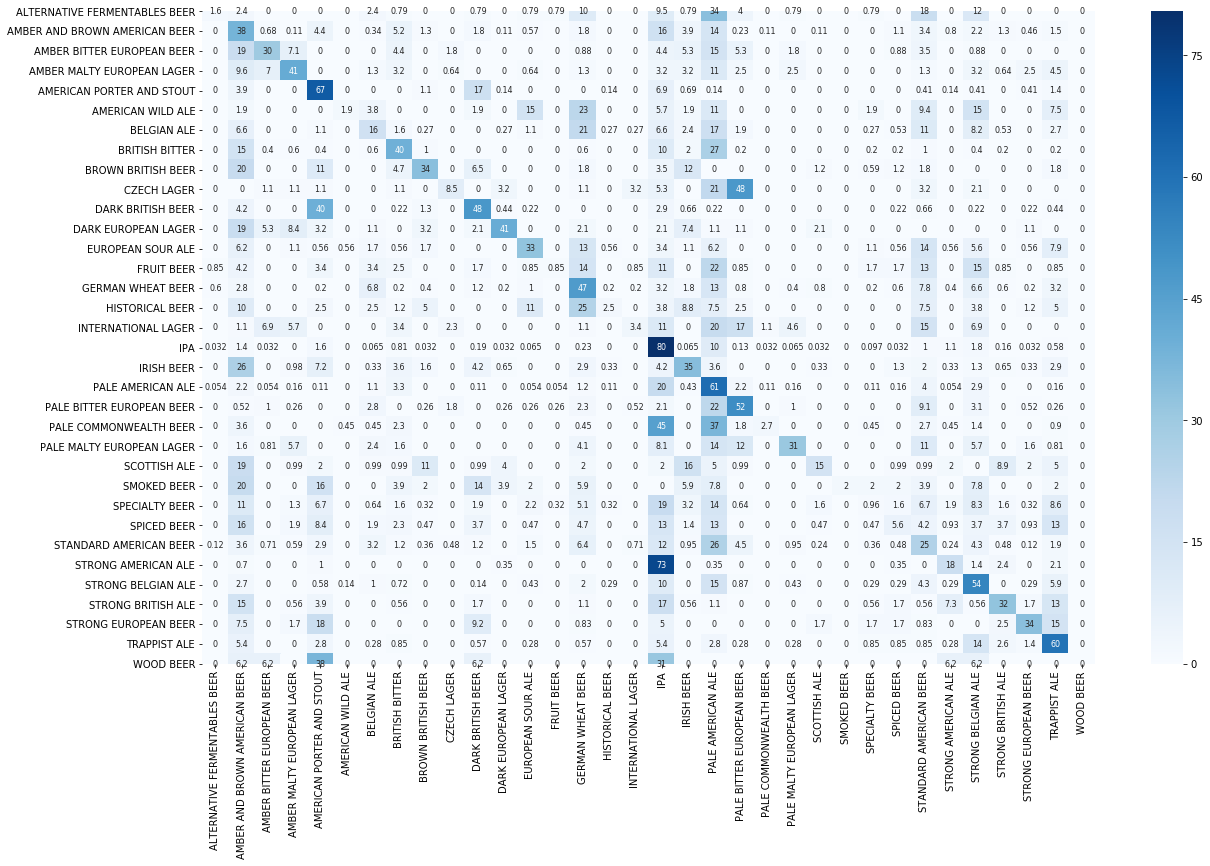

In [45]:
# Produce the confusion matrix
cm = confusion_matrix(y_test, y_test_preds, labels=np.unique(y_test))

# Store the labels of the categories
label, _ = np.unique(y_test, return_counts=True)

# Create a dataframe and compute the percentage per row
confusion_mat = pd.DataFrame(cm, columns=label, index=label)
confusion_mat = confusion_mat.divide(confusion_mat.sum(axis=1), axis=0) * 100

plt.figure(figsize=(20, 12))
ax = heatmap(confusion_mat, annot=True, annot_kws={"size": 8}, cmap="Blues")

<b> From this confusion matrix, here are some results that show the styles may be overlapping. These are areas where the model performs poorly and could inform Beer Makers on how to better classify styles.
</b>

|                      	| American Porter and Stout 	| Pale Commonwealth Ale             	| Strong American Ale 	|
|----------------------	|---------------------------	|-----------------------------------	|---------------------	|
| Correctly classified 	|            65%            	|                11%                	|         45%         	|
| Mis-classified       	|   22% Dark British Beer   	| 31% - IPA 30% - Pale American Ale 	|       36% IPA       	|

<b> We used the classification report to look at the results by classes with our North Star metric, F1-score, as well as performance with accuracy, precision and recall scores. 
* Our weighted f1-score is 0.46, recall is 0.49, and precision is 0.46. Precision and recall being similar seems to indicate our model is getting false positives and false negatives in approximately equal quantities
* Our accuracy is 0.49, and even with some imbalanced classes achieving this across 34 styles is pretty good (at least compared to what a human could achieve)
</b>

In [47]:
print(classification_report(y_test, y_test_preds))

                               precision    recall  f1-score   support

ALTERNATIVE FERMENTABLES BEER       0.22      0.02      0.03       126
AMBER AND BROWN AMERICAN BEER       0.34      0.38      0.36       878
   AMBER BITTER EUROPEAN BEER       0.43      0.30      0.35       113
   AMBER MALTY EUROPEAN LAGER       0.52      0.41      0.46       157
    AMERICAN PORTER AND STOUT       0.52      0.67      0.58       726
            AMERICAN WILD ALE       0.25      0.02      0.04        53
                  BELGIAN ALE       0.31      0.16      0.21       376
               BRITISH BITTER       0.47      0.40      0.43       496
           BROWN BRITISH BEER       0.46      0.34      0.39       170
                  CZECH LAGER       0.33      0.09      0.14        94
            DARK BRITISH BEER       0.48      0.48      0.48       454
          DARK EUROPEAN LAGER       0.66      0.41      0.51        95
            EUROPEAN SOUR ALE       0.47      0.33      0.39       178
     

<b>There seems to be some correlation between support and f1-score</b>

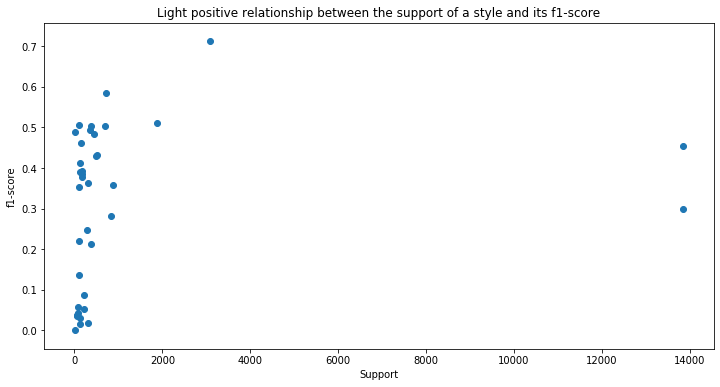

In [51]:
# Store classification report in data frame and look
cr_df = pd.DataFrame(classification_report(y_test, y_test_preds, output_dict=True)).transpose()
plt.figure(figsize=(12,6))
plt.scatter(cr_df.support, cr_df['f1-score'])
plt.xlabel('Support')
plt.ylabel('f1-score')
plt.title('Light positive relationship between the support of a style and its f1-score')
plt.show()

## Conclusion
-----

We learned a lot in this end-to-end effort of formulating a problem, processing data, coming up with an initial model, iterating, and interpreting our results. Our main takeaways are listed below:
* In our situation, the labels of our target variable (Style of Beer) were developed in a subjective, human manner. Beer Judges creat categories that don't exactly map to the features that are present in our data. They may group beers for historical or geographic reasons, and not always exclusively because of factors like ABV or IBUs. Therefore there is a lot of inherent overlap in the classes based on our features, and we believe that explained the ceiling we had in our weighted f1-score (<0.50)
<br><br>
* Random Forest performed the best by far, even with overfitting. We were never able to get our training score down to a similar level as our CV-scores. Again, this may be due to the fact that our data wasn't able to describe the true distribution of beer styles well enough.
<br><br>
* If Beer Makers wanted to create new style categories that are more in-line with the physical properties of the recipe (Specific Gravity, Color, ABV, etc.), the results of our model could help inform where there is a lot of overlap/confusion between styles currently.
<br><br>
* Finally, the ceiling on our f1-score could also in large part be due to missing significant exogenous variables. The ones we believe could be very helpful are where the recipe was brewed (country) and list of ingredients used in the recipe. 